<h2>A binary classification task of pulsar stars</h2>
<i>based on a dataset from <a href="https://www.kaggle.com/pavanraj159/predicting-a-pulsar-star">kaggle.com</a></i><br>
<br>
<b>Contents:</b>
<ol> 
    <li>Introduction</li>
    <li>Data preparation</li>
    <li>Preliminary studies</li>
    <li>Score and resampling</li>
    <li>Models</li>
    <ul>
        <li>Linear SVM</li>
        <li>K Nearest Neighbors</li>
        <li>Polynomial SVM</li>
        <li>PCA + Linear SVM</li>
        <li>Neural Network</li>
    </ul>
    <li>Conclusions</li>
</ol>



<h3>1. Introduciton</h3>
<p>This is a study exploring a binary classification task for pulsar stars. We describe our approach to the problem and shortly discuss our reasoning.</p>

<p>On the level of data preparation, we have identified and addressed the problem of imbalanced datasets by resampling the training set using the <a href="iojio">SMOTE algorithm</a>. Moreover, as a performance measure we use the Precision-Recall Plot and Average Precision scoring as <a href="saito2015.pdf">more suitable measure</a> for binary classification tasks for imbalanced datasets.  

<p>The choice of models is quite conservative. First choice of Support Vector Machines and K Nearest Neighbors Model essentially follows the <a href="https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html">scikit-learn flow-chart</a>. Besides that, we also apply the Principal Component Analysis (PCA) as a preliminary step in the pipeline as the characteristics provided in the dataset could be depedendent. Lastly, we decide to train a simple Neural Network Model.</p>


<h3>2. Data preparation</h3>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.svm import LinearSVC,SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split,cross_val_score, KFold, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import average_precision_score,precision_recall_curve,accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier


import pickle
import os

#SMOTE algorithm
from imblearn.over_sampling import SMOTE,BorderlineSMOTE


/home/grela/.local/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [2]:
data = pd.read_csv('pulsar_stars.csv')

# rename columns
newcols = ['mean_profile','std_profile','kurt_profile','skew_profile','mean_curve','std_curve','kurt_curve','skew_curve','target_class']
oldcols = data.columns.to_list()
data = data.rename(columns=dict(zip(oldcols,newcols)))

# sklearn split into train/test datasets
Xtrain,Xtest,ytrain,ytest = train_test_split(data.iloc[:,:-1],data.iloc[:,-1],random_state=0,train_size=0.8)
datatrain = pd.concat([Xtrain,ytrain],ignore_index=False,axis=1)
datetest = pd.concat([Xtest,ytest],ignore_index=False,axis=1)

# summary of studied models
model_results = pd.DataFrame()


<h3>3. Preliminary studies</h3>

              mean_profile  std_profile  kurt_profile  skew_profile  \
mean_profile      1.000000     0.549804     -0.876250     -0.741640   
std_profile       0.549804     1.000000     -0.526139     -0.543705   
kurt_profile     -0.876250    -0.526139      1.000000      0.946182   
skew_profile     -0.741640    -0.543705      0.946182      1.000000   
mean_curve       -0.300813     0.005110      0.413890      0.410917   
std_curve        -0.313302    -0.052372      0.436995      0.418872   
kurt_curve        0.243241     0.036216     -0.346322     -0.333477   
skew_curve        0.152848     0.034563     -0.219231     -0.209297   
target_class     -0.677220    -0.366648      0.790853      0.706890   

              mean_curve  std_curve  kurt_curve  skew_curve  target_class  
mean_profile   -0.300813  -0.313302    0.243241    0.152848     -0.677220  
std_profile     0.005110  -0.052372    0.036216    0.034563     -0.366648  
kurt_profile    0.413890   0.436995   -0.346322   -0.219231  

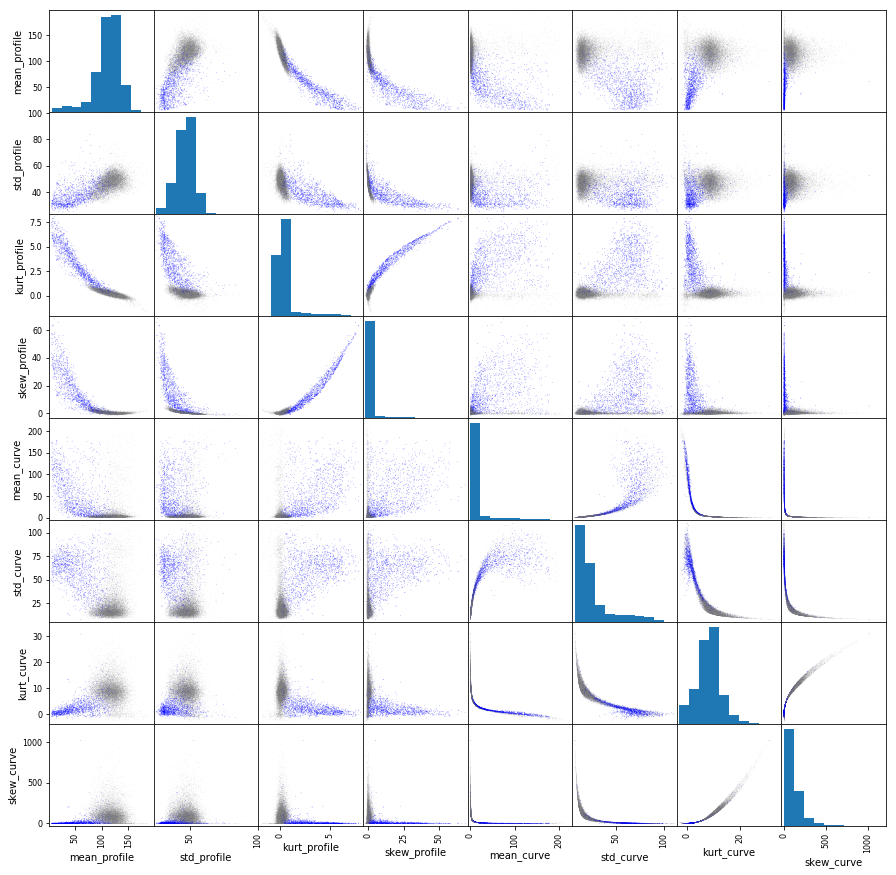

In [8]:
#correlation matrix
print(datatrain.corr())

#scatter_matrix plots for train dataset 

color = {1:'blue',0:'gray'}
sizes = {1:2,0:.5}
datasample = datatrain.sample(frac=1)[:]
#datasample.plot.scatter(x='mean_profile',y='std_profile',figsize=[6,6],c=datasample['target_class'].apply(lambda x: color[x]),marker='x')
#plot = datasample.plot.scatter(x='skew_curve',y='kurt_curve',figsize=[5,5],c=datasample['target_class'].apply(lambda x: color[x]),marker='.',s=datasample['target_class'].apply(lambda x: sizes[x]))

plots = pd.plotting.scatter_matrix(datasample.iloc[:,:-1],figsize=[15,15],c=datasample['target_class'].apply(lambda x: color[x]),marker='.',s=datasample['target_class'].apply(lambda x: sizes[x]))


<h3>4. Score and resampling</h3>

Average precision-recall score: 0.9281656572303744



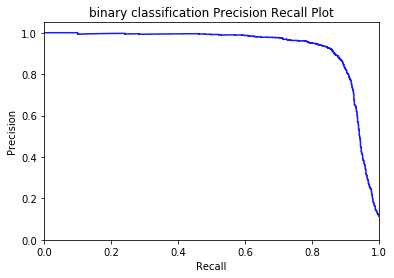

In [3]:
# Precision Recall Plot function
def PrecisionRecallPlot(classifier,Xtrain,ytrain):
    classifier.fit(X=Xtrain,y=ytrain)
    y_score = classifier.decision_function(Xtrain)

    average_precision = average_precision_score(ytrain, y_score)
    precision, recall, thresholds = precision_recall_curve(ytrain, y_score)
    print()
    plt.step(recall, precision, color='b', alpha=0.9,
             where='post')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('binary classification Precision Recall Plot')
    plt.show()

# Average Precision Recall Score function
def AvPrecisionScore(classifier,Xtrain,ytrain):
    classifier.fit(X=Xtrain,y=ytrain)
    y_score = classifier.decision_function(Xtrain)
    average_precision = average_precision_score(ytrain, y_score)
    return average_precision

# basic PR Plot
clfSVC = LinearSVC(C=1,dual=False,class_weight={0:1,1:1})
print('Average precision-recall score:',AvPrecisionScore(clfSVC,Xtrain,ytrain))
PrecisionRecallPlot(clfSVC,Xtrain,ytrain)


Average precision-recall score: 0.981126727213374



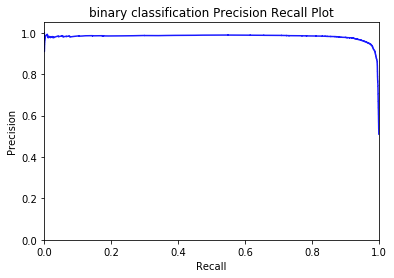

In [5]:
# resampling with SMOTE algorithm

#resampler = SMOTE()
resampler = BorderlineSMOTE()
Xtrain_resampled,ytrain_resampled = resampler.fit_resample(Xtrain,ytrain)

# improvement of PR Plot due to resampling
clfSVC = LinearSVC(C=1,dual=False,class_weight={0:1,1:1})
print('Average precision-recall score:',AvPrecisionScore(clfSVC,Xtrain_resampled,ytrain_resampled))
PrecisionRecallPlot(clfSVC,Xtrain_resampled,ytrain_resampled)

<h3>5. Models</h3>

In [6]:
MgridParams = {}

MgenParams = {}
Mdatasets = {}

Mfound = {}
Mclfs = {}

Mscores = {}

#flag to save classifiers
clfSave = True

#define parameters scope for GridSearchCV
MgridParams['LinearSVC'] = [{'C':[0.5,1,1.5,2],'class_weight':[None]}]
MgridParams['KNearestNeighbors'] = [{'n_neighbors':[1,2,3,4,5,6],'weights':['distance','uniform']}]
MgridParams['PolySVC'] = [{'kernel':['poly'],'class_weight':[{0:1,1:1},{0:8,1:1},'balanced'],'degree':[3,4,5,6]}]
MgridParams['PCALinearSVC'] = [{'C':[0.5,1,1.5,2],'class_weight':[None]}]
MgridParams['NeuralNetwork'] = [{'hidden_layer_sizes':[(8,4,2,),(6,2,1,),(6,2,)],'activation':['relu','tanh']}]

#define general parameters
MgenParams['LinearSVC'] = {'cv':StratifiedKFold(n_splits=5,shuffle=True),'scoring':'average_precision','n_jobs':-1}
MgenParams['KNearestNeighbors'] = {'cv':StratifiedKFold(n_splits=5,shuffle=True),'scoring':'average_precision','n_jobs':-1}
MgenParams['PolySVC'] = {'cv':StratifiedKFold(n_splits=5,shuffle=True),'scoring':'average_precision','n_jobs':-1}
MgenParams['PCALinearSVC'] = {'cv':StratifiedKFold(n_splits=5,shuffle=True),'scoring':'average_precision','n_jobs':-1}
MgenParams['NeuralNetwork'] = {'cv':StratifiedKFold(n_splits=5,shuffle=True),'scoring':'average_precision','n_jobs':-1}

#define datasets
X0,y0=Xtrain_resampled,ytrain_resampled
#X0,y0=Xtrain,ytrain

Mdatasets['LinearSVC'] = {'X':X0,'y':y0}
Mdatasets['KNearestNeighbors'] = {'X':X0,'y':y0}
Mdatasets['PolySVC'] = {'X':X0,'y':y0}
Mdatasets['PCALinearSVC'] = {'X':PCA(n_components=3).fit_transform(X0),'y':y0}
Mdatasets['NeuralNetwork'] = {'X':StandardScaler().fit_transform(X0),'y':y0}

#define classifiers
Mclfs['LinearSVC'] = LinearSVC(dual=False)
Mclfs['KNearestNeighbors'] = KNeighborsClassifier()
Mclfs['PolySVC'] = SVC(gamma='scale')
Mclfs['PCALinearSVC'] = LinearSVC(dual=False)
Mclfs['NeuralNetwork'] = MLPClassifier(max_iter=400)

#define flags
Mfound['LinearSVC'] = True
Mfound['KNearestNeighbors'] = True
Mfound['PolySVC'] = True
Mfound['PCALinearSVC'] = True
Mfound['NeuralNetwork'] = False

# save the classifier
def save_clf(m):
    clf = Mclfs[m]
    clf.set_params(**Mscores[m]['params'])
    filename='clf_'+m+'.pkl'
    clf.fit(**Mdatasets[m])
    with open(filename,'wb') as f: pickle.dump(clf,f)

# load the classifier
def load_clf(filename):
    # load the classifier
    with open(filename,'rb') as f: clf = pickle.load(f)
    return clf

In [7]:
#run to reset flags 
for m in MgridParams: Mfound[m] = False

In [8]:
#main loop

for m in Mclfs: 
    print('Searching for optimal model:',m,'...')
    if not Mfound[m]:
        clf = GridSearchCV(Mclfs[m],MgridParams[m],**MgenParams[m])
        clf.fit(**Mdatasets[m])
        result = pd.DataFrame(clf.cv_results_)
        Mscores[m] = result[result['rank_test_score']==1].iloc[0,:][['mean_test_score','std_test_score','params']]
        if clfSave: save_clf(m)
        Mfound[m] = True
        
    print('Done')
    

Searching for optimal model: LinearSVC ...
Done
Searching for optimal model: KNearestNeighbors ...
Done
Searching for optimal model: PolySVC ...


/home/grela/.local/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Done
Searching for optimal model: PCALinearSVC ...
Done
Searching for optimal model: NeuralNetwork ...
Done


<h3>6. Conclusions</h3>

In [42]:
# from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

confusion matrix for LinearSVC is


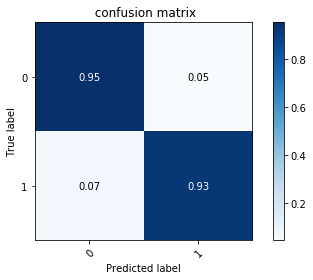

AP for LinearSVC reads 0.6258877395596314



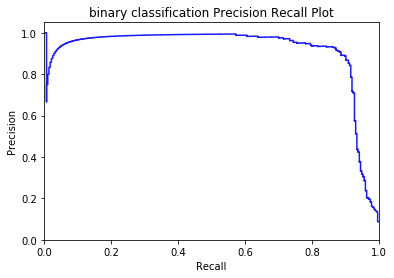

confusion matrix for KNearestNeighbors is


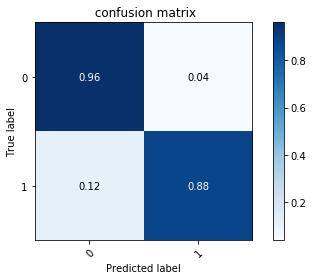

AP for KNearestNeighbors reads 0.6121446415945074
confusion matrix for PolySVC is


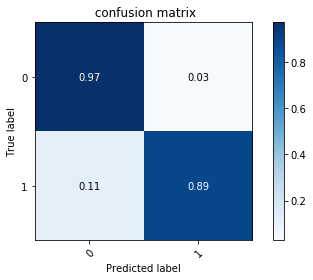

AP for PolySVC reads 0.6641318728197921



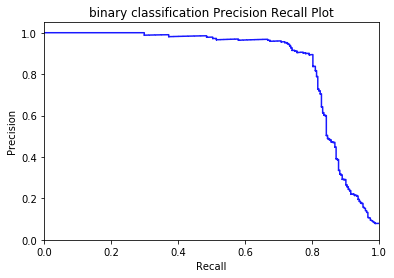

confusion matrix for PCALinearSVC is


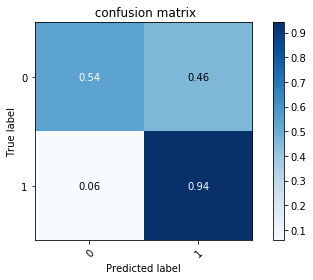

AP for PCALinearSVC reads 0.5618223108476262



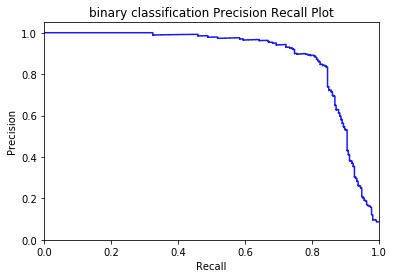

confusion matrix for NeuralNetwork is


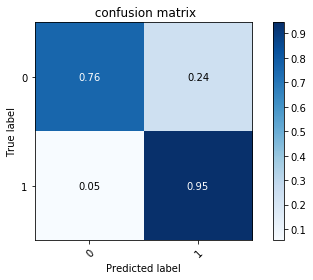

AP for NeuralNetwork reads 0.45428644442903166


In [43]:
# measure performance by average precision on test dataset
testScores = {}
class_names={0:'non-pulsar',1:'pulsar'}

X0,y0=Xtest,ytest
Mdatasets['LinearSVC'] = {'X':X0,'y':y0}
Mdatasets['KNearestNeighbors'] = {'X':X0,'y':y0}
Mdatasets['PolySVC'] = {'X':X0,'y':y0}
Mdatasets['PCALinearSVC'] = {'X':PCA(n_components=3).fit_transform(X0),'y':y0}
Mdatasets['NeuralNetwork'] = {'X':StandardScaler().fit_transform(X0),'y':y0}

PRplots = {}
PRplots['LinearSVC'] = True
PRplots['KNearestNeighbors'] = False
PRplots['PolySVC'] = True
PRplots['PCALinearSVC'] = True
PRplots['NeuralNetwork'] = False

clfList=['LinearSVC','KNearestNeighbors','PolySVC','PCALinearSVC','NeuralNetwork']
for clfname in clfList:
    Xcurrent = Mdatasets[clfname]['X']
    ycurrent = Mdatasets[clfname]['y']
    clf = load_clf('clf_'+clfname+'.pkl')
    yhat = clf.predict(Xcurrent)
    print('confusion matrix for',clfname,'is')
    plot_confusion_matrix(ycurrent, yhat, classes=class_names, normalize=True,title=' confusion matrix')
    plt.show()
    #print(confusion_matrix(ycurrent,yhat))
    testScores[clfname] = average_precision_score(yhat,ycurrent)
    print('AP for',clfname,'reads',testScores[clfname])
    if PRplots[clfname]: PrecisionRecallPlot(clf,Xcurrent,ycurrent)
    print('==============================')


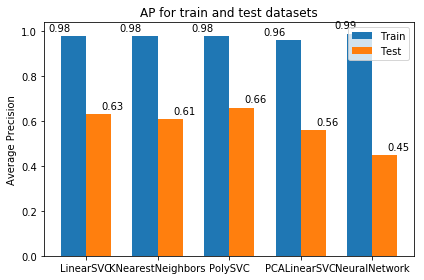

In [14]:
# bar plot with performances for train and test datasets
# https://matplotlib.org/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py

train = [Mscores[m]['mean_test_score'].round(2) for m in clfList]
test = [testScores[m].round(2) for m in clfList]

ind = np.arange(len(train))  # the x locations for the groups
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind - width/2, train, width,label='Train')
rects2 = ax.bar(ind + width/2, test, width,label='Test')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Average Precision')
ax.set_title('AP for train and test datasets')
ax.set_xticks(ind)
ax.set_xticklabels(clfList)
ax.legend()


def autolabel(rects, xpos='center'):
    """
    Attach a text label above each bar in *rects*, displaying its height.

    *xpos* indicates which side to place the text w.r.t. the center of
    the bar. It can be one of the following {'center', 'right', 'left'}.
    """

    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0, 'right': 1, 'left': -1}

    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(offset[xpos]*3, 3),  # use 3 points offset
                    textcoords="offset points",  # in both directions
                    ha=ha[xpos], va='bottom')


autolabel(rects1, "left")
autolabel(rects2, "right")

fig.tight_layout()

plt.show()

<b>Conclusions</b>
<ul>
    <li>Measuring Average Precision on the test dataset shows that SVM's are generally most suitable for the task at hand. In the LinearSVC case, PR plot reveals a curious behavior near zero recall point which needs further study.</li>
    <li>In comparison to SVM's, both K Nearest Neighbors method and Neural Network approach achieved worse performance on real data.</li>
    <li>Computation of confusion matrices reveals how each classifier performs. LinearSVC, PolySVC and KNearestNeighbors have overall low error levels with slight prevalence of type-2 errors (true-negative). On the other hand, PCALinearSVC and NeuralNetwork suffer from many type-1 errors (false-positive) which is also reflected in lower AP scores.</li>
</ul>